In [1]:
import sys
sys.path.insert(0, '../tools')

%load_ext prov_magics
import provn

In [2]:
from pprint import pprint
import annotations as prov

3


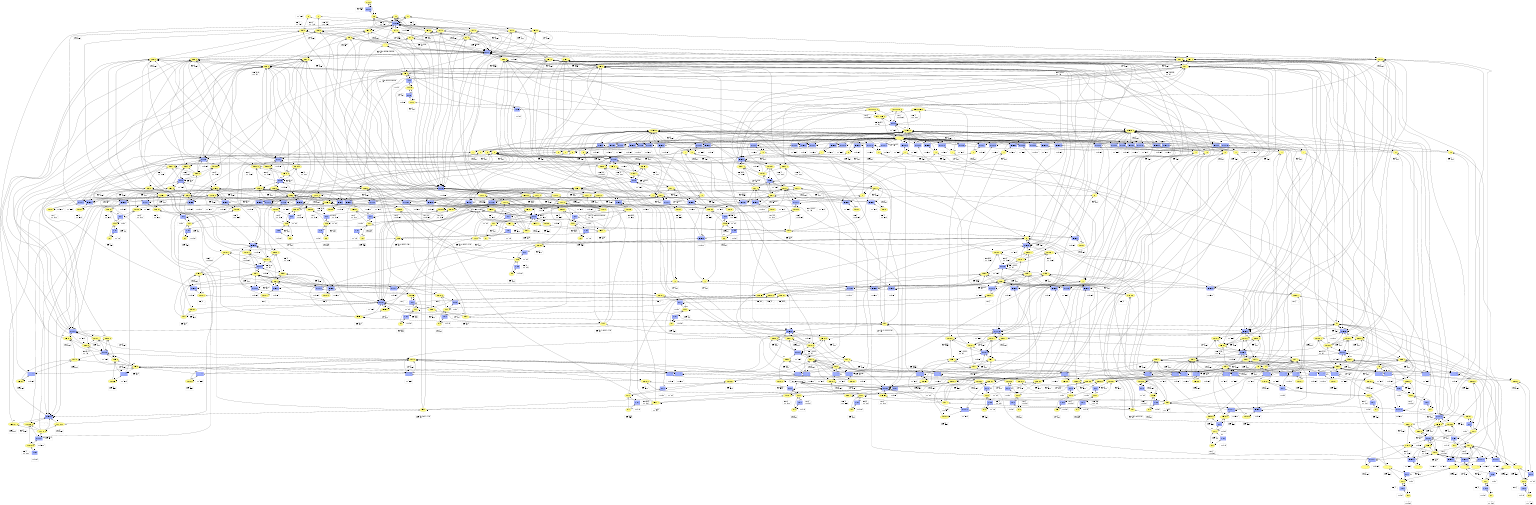

[('used', 602),
 ('entity', 354),
 ('wasDerivedFrom', 352),
 ('wasGeneratedBy', 346),
 ('activity', 212),
 ('hadMember', 177)]


In [5]:
import importlib
import annotations as prov
importlib.reload(prov)
prov.reset_prov()

# Line 1
m = 10000 # max value

with prov.desc("L1 - assign"):
    e_n10000 = prov.entity("n", "10000", "literal", num=10000)

    e_m = prov.entity("m", "10000", "name")
    prov.activity("assign", [(e_m, e_n10000)])

# Line 2
result = dist = [
    [0, 1, 4],
    [m, 0, 2],
    [2, m, 0],
]

with prov.desc("L2 - list definition / assign"):
    
    with prov.desc("list definition"):
        e_n0 = prov.entity("n", "0", "literal", num=0)
        e_n1 = prov.entity("n", "1", "literal", num=1)
        e_n2 = prov.entity("n", "2", "literal", num=2)
        e_n4 = prov.entity("n", "4", "literal", num=4)

        prov_dist = [
            [e_n0, e_n1, e_n4],
            [e_m, e_n0, e_n2],
            [e_n2, e_m, e_n0],
        ]
        
        e_list, rows = prov.define_array("list", dist, "list", prov.hadMember)

        derived = []
        generated = [e_list]
        for i, row in enumerate(rows):
            generated.append(row[0])
            for j, ent in enumerate(row[1]):
                derived.append((ent, prov_dist[i][j]))
            
        prov.activity("definelist", derived, generated=generated)
        
    with prov.desc("assign"):
        e_dist, _ = prov.define_array("dist", dist, "list", prov.hadMember)
        e_result, _ = prov.define_array("result", result, "list", prov.hadMember)
        
        dder = prov.derivation_pair(e_dist, e_list)
        rder = prov.derivation_pair(e_result, e_list)
        
        prov.activity("assign", dder)
        prov.activity("assign", rder)

# Line 7
nodes = len(dist)

with prov.desc("L7 - func call / assign"):
    e_ret = prov.entity("len_dist", repr(nodes), "eval")
    prov.activity("len", [], [e_dist], [e_ret])
    
    e_nodes = prov.entity("nodes", repr(nodes), "name")
    prov.activity("assign", [(e_nodes, e_ret)])

# Line 8
indexes = range(nodes)

with prov.desc("L8 - func call / list assign"):
    e_ret, _ = prov.define_array("range_nodes", indexes, "list", prov.hadMember)
    prov.activity("range", [], [e_nodes], [e_ret])
    
    e_indexes, _ = prov.define_array("indexes", indexes, "list", prov.hadMember)
    der = prov.derivation_pair(e_indexes, e_ret)
    prov.activity("assign", der)

# Line 9
for k in indexes:
    with prov.desc("L9 - loop access"):
        e_k = prov.entity("k", k, "name")
        prov.activity("access", [(e_k, prov.DICTS[e_indexes][repr(k)])], used=[e_indexes])
    
    # Line 10
    distk = dist[k]
    
    with prov.desc("L10 - access / assign"):
        e_dist_ak, _ = prov.define_array("dist_ak", distk, "list", prov.hadMember)
        item = prov.DICTS[e_dist][str(k)]
        der = prov.derivation_pair(e_dist_ak, item)
        prov.activity("access", der, used=[e_dist, e_k])

        e_distk, _ = prov.define_array("distk", distk, "list", prov.hadMember)
        der = prov.derivation_pair(e_distk, e_dist_ak)
        prov.activity("assign", der)
    
    # Line 11
    for i in indexes:
        with prov.desc("L11 - loop access"):
            e_i = prov.entity("i", k, "name")
            prov.activity("access", [(e_i, prov.DICTS[e_indexes][repr(i)])], used=[e_indexes])
        
        # Line 12
        disti = dist[i]
        
        with prov.desc("L12 - access / assign"):
            e_dist_ai, _ = prov.define_array("dist_ai", disti, "list", prov.hadMember)
            item = prov.DICTS[e_dist][str(i)]
            der = prov.derivation_pair(e_dist_ai, item)
            prov.activity("access", der, used=[e_dist, e_i])

            e_disti, _ = prov.define_array("disti", disti, "list", prov.hadMember)
            der = prov.derivation_pair(e_disti, e_dist_ai)
            prov.activity("assign", der)
        
        # Line 13
        for j in indexes:
            with prov.desc("L13 - loop access"):
                e_j = prov.entity("j", k, "name")
                prov.activity("access", [(e_j, prov.DICTS[e_indexes][repr(j)])], used=[e_indexes])
            
            # Line 14
            ikj = disti[k] + distk[j]
            
            with prov.desc("L14 - access / access / operation / assign"):
                e_disti_ak = prov.entity("disti_ak", repr(disti[k]), "access")
                item = prov.DICTS[e_disti][str(k)]
                prov.activity("access", [(e_disti_ak, item)], used=[e_disti, e_k])
                
                e_distk_aj = prov.entity("distk_aj", repr(distk[j]), "access")
                item = prov.DICTS[e_distk][str(j)]
                prov.activity("access", [(e_distk_aj, item)], used=[e_distk, e_j])
                
                e_sum = prov.entity("sum", repr(ikj), "sum")
                prov.activity("add", [(e_sum, e_disti_ak, e_distk_aj)])
                
                e_ikj = prov.entity("ikj", repr(ikj), "name")
                prov.activity("e_ikj", [(e_ikj, e_sum)])
                
            
            # Line 15
            with prov.desc("L15 - access"):
                e_disti_aj = prov.entity("disti_aj", repr(disti[j]), "access")
                item = prov.DICTS[e_disti][str(j)]
                prov.activity("access", [(e_disti_aj, item)], used=[e_disti, e_j])
            
            if disti[j] > ikj:
                
                # Line 16
                disti[j] = ikj
                
                with prov.desc("L16 - part assign with propagation"):
                    derived = []
                    used = [e_disti_aj] # from if
                    generated = []
                    
                    
                    e_disti_aj = prov.entity("disti_aj", repr(ikj), "access")
                    new_e_disti = prov.update("disti", e_disti, j, e_disti_aj, disti)
                    
                    derived.append((e_disti_aj, ikj))
                    used.append(e_disti)
                    generated.append(new_e_disti)
                    
                    new_e_distk = e_distk
                    if i == k:
                        e_distk_aj = prov.entity("distk_aj", repr(ikj), "access")
                        new_e_distk = prov.update("distk", e_distk, j, e_distk_aj, distk)
                        derived.append((e_distk_aj, ikj))
                        used.append(e_distk)
                        generated.append(new_e_distk)
                    
                    e_dist_uaij = prov.entity("dist{}{}_".format(i, j), repr(ikj), "access")
                    e_item = prov.DICTS[e_dist][str(i)]
                    e_dist_uai = prov.update("dist{}_".format(i), e_item, j, e_dist_uaij, disti)
                    derived.append((e_dist_uaij, ikj))
                    used.append(e_item)
                    generated.append(e_dist_uai)
                    
                    new_e_dist = prov.update("dist", e_dist, i, e_dist_uai, dist)
                    used.append(e_dist)
                    generated.append(new_e_dist)
                    
                    e_result_uaij = prov.entity("result{}{}_".format(i, j), repr(ikj), "access")
                    e_item = prov.DICTS[e_result][str(i)]
                    e_result_uai = prov.update("result{}_".format(i), e_item, j, e_result_uaij, disti)
                    derived.append((e_result_uaij, ikj))
                    used.append(e_item)
                    generated.append(e_result_uai)
                    
                    new_e_result = prov.update("result", e_result, i, e_result_uai, result)
                    used.append(e_result)
                    generated.append(new_e_result)
            
                    prov.activity("assign", derived, used=used, generated=generated)
                    
                    e_disti = new_e_disti
                    e_distk = new_e_distk
                    e_dist = new_e_dist
                    e_result = new_e_result
                    
                    
                    
                

# Line 17
print(result[0][2])

with prov.desc("L17 - access / access / call"):
    e_result_a0, _ = prov.define_array("result_a0", result[0], "list", prov.hadMember)
    item = prov.DICTS[e_result]["0"]
    der = prov.derivation_pair(e_result_a0, item)
    prov.activity("access", der, used=[e_result, e_n0])
            
    e_result_a02 = prov.entity("result_a02", repr(result[0][2]), "number")
    item = prov.DICTS[e_result_a0]["2"]
    prov.activity("access", [(e_result_a02, item)], used=[e_result_a0, e_n2])
    
    prov.activity("print", [], [e_result_a02])

pprint(prov.stats("../plain_prov/floydwarshall", True))

In [ ]:
ip = get_ipython()